In [13]:
from neurodiffeq import diff
from neurodiffeq.solvers import Solver1D, Solver2D
from neurodiffeq.conditions import IVP, DirichletBVP2D
from neurodiffeq.networks import FCNN, SinActv, Resnet, Swish, MonomialNN
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp,odeint
import torch
import torch.nn as nn
from neurodiffeq.generators import Generator1D
import math
from neurodiffeq.monitors import Monitor1D
import IPython

In [14]:
alpha0 = 2
alpha1 = 1
C0 = -alpha0/(alpha1)
C1 = 2
C2 = 3
C3 = 4
C4 = 5

Training Progress:   0%|                              | 0/50000 [00:00<?, ?it/s]

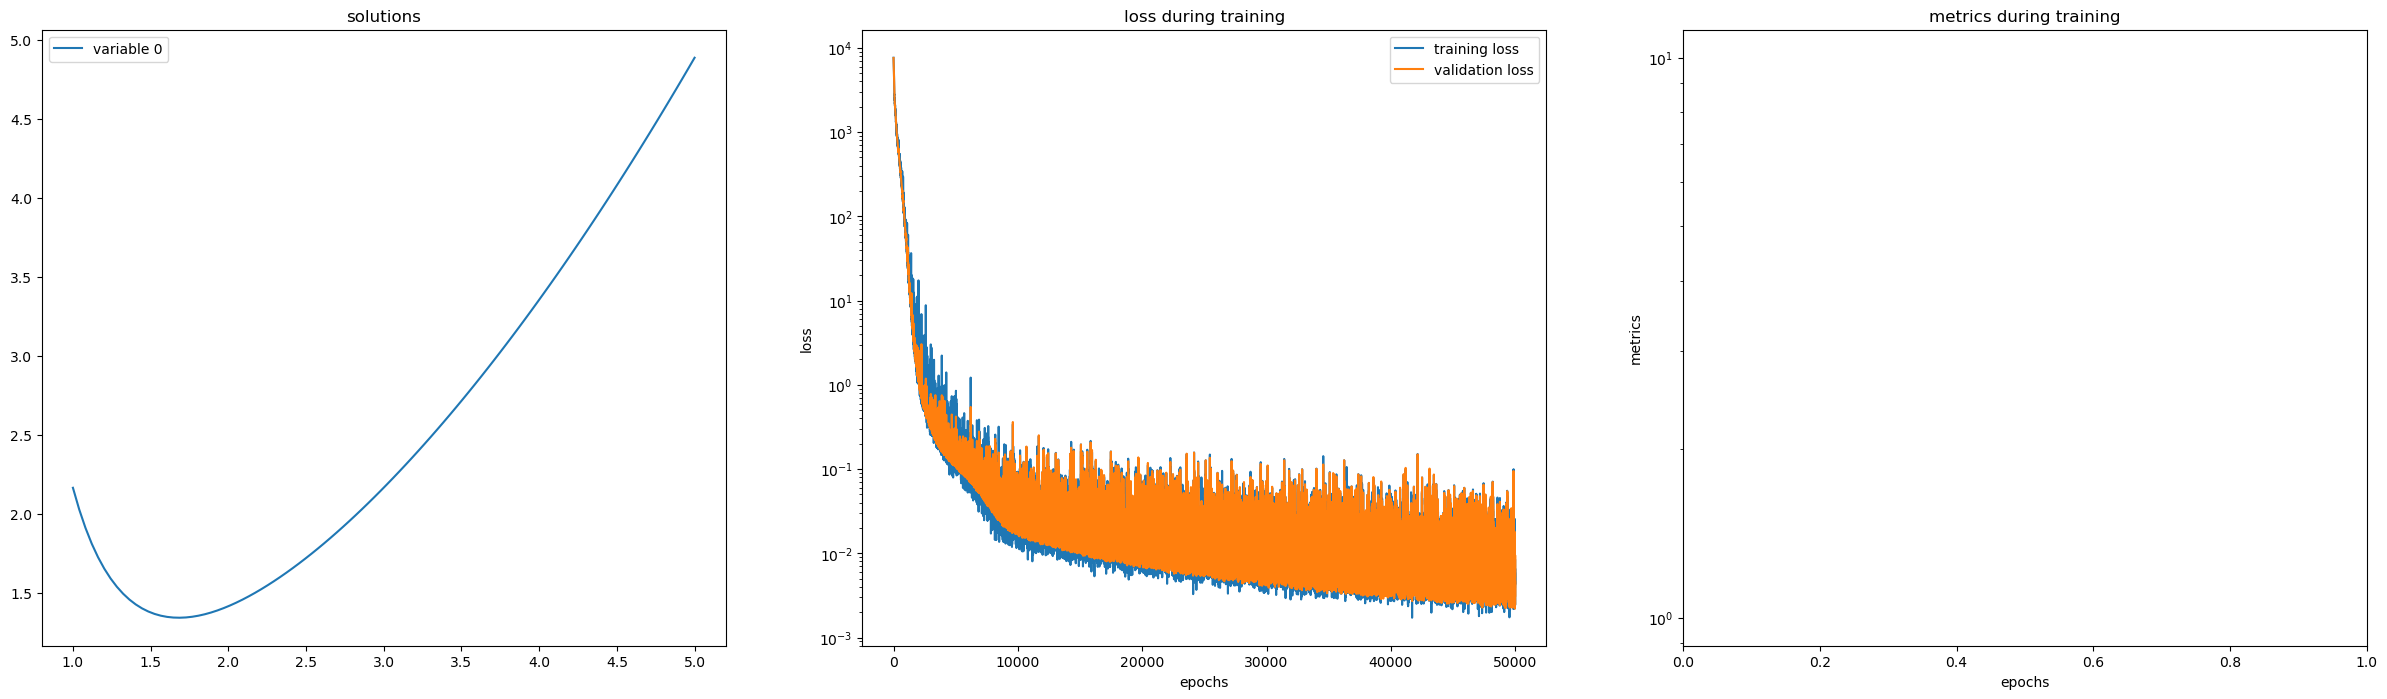

In [28]:
def ode_system(U, t):
    return [torch.pow(t,2)*diff(U,t,order=2) + 4*t*diff(U,t) + 2*U - (torch.pow(t,2)*alpha0)/alpha1 - 2]
N = 50000
t_start = 1.0
t_end = 5.0
t = np.linspace(t_start, t_end, N)
U0 = 1 - C0/12 - C1 + C2
U0dash = -C0/6 + C1 - 2*C2

conditions = [IVP(t_0=1.0, u_0=U0, u_0_prime=U0dash)]

nets = [FCNN(actv=SinActv)]

g1 = Generator1D(4096, t_start, t_end, method='uniform')
monitor = Monitor1D(t_min=t_start, t_max=t_end, check_every=N)
# solver = Solver1D(ode_system, conditions, t_min=t_start, t_max=t_end, nets = nets, train_generator=g1, valid_generator=g1)
solver = Solver1D(ode_system, conditions, t_min=t_start, t_max=t_end, nets = nets)
solver.fit(max_epochs=N, callbacks = [monitor.to_callback()])
solution = solver.get_solution()

In [31]:
U_nn = solution(t, to_numpy=True)
U_an = 1 - (C0/12)*t**2 - C1/t + C2/(t**2)

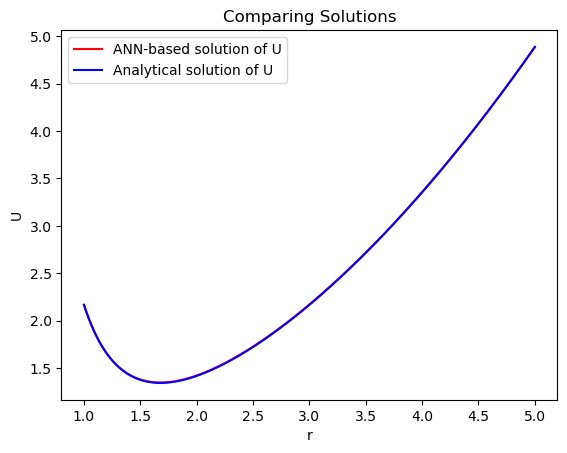

In [32]:
plt.title("Comparing Solutions")
plt.ylabel('U')
plt.xlabel('r')
plt.plot(t, U_nn, label='ANN-based solution of U', color = 'r')
plt.plot(t, U_an,label='Analytical solution of U', color = 'b')
plt.legend()
plt.savefig('fR_SR_solution_1_2', dpi = 300)
plt.show()

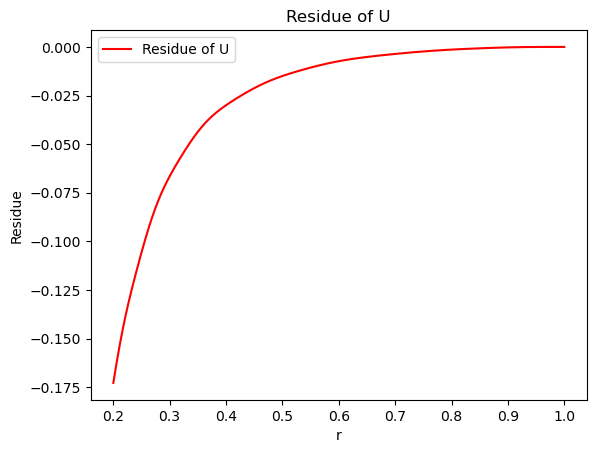

In [26]:
plt.title("Residue of U")
plt.ylabel('Residue')
plt.xlabel('r')
plt.plot(t, U_nn-U_an, label='Residue of U', color = 'r')
plt.legend()
plt.savefig('fR_SR_residue_1_1', dpi = 300)
plt.show()

In [32]:
lambda_error = np.sqrt(np.mean((U_nn-U_an)**2))
print("Mean square error in lambda is", lambda_error)

Mean square error in lambda is 0.009225770473149599


In [34]:
# Initial conditions
h = t[1]-t[0]

# Enter the definition of the set of ordinary differential equations
def ode(t,y,u):
  ode_1 = u
  ode_2 = alpha0/alpha1 + 2/(t**2) - 4*u/t - 2*y/(t**2)
  return np.array([ode_1,ode_2])

# RK4
y = np.empty(N); u = np.empty(N)

# t[0] = t_initial
y[0] = U0; u[0] = U0dash

for i in range(0,N-1,1):

  k11 = h*ode(t[i],y[i],u[i])[0]
  k12 = h*ode(t[i],y[i],u[i])[1]

  k21 = h*ode(t[i]+(h/2),y[i]+(k11/2),u[i]+(k12/2))[0]
  k22 = h*ode(t[i]+(h/2),y[i]+(k11/2),u[i]+(k12/2))[1]

  k31 = h*ode(t[i]+(h/2),y[i]+(k21/2),u[i]+(k22/2))[0]
  k32 = h*ode(t[i]+(h/2),y[i]+(k21/2),u[i]+(k22/2))[1]

  k41 = h*ode(t[i]+h,y[i]+k31,u[i]+k32)[0]
  k42 = h*ode(t[i]+h,y[i]+k31,u[i]+k32)[1]

  y[i+1] = y[i] + ((k11+2*k21+2*k31+k41)/6)
  u[i+1] = u[i] + ((k12+2*k22+2*k32+k42)/6)
  # t[i+1] = t[i] + h

In [35]:
U_rk4 = y

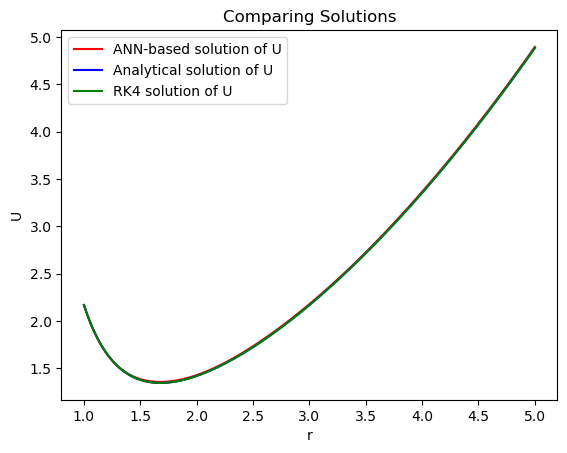

In [48]:
plt.title("Comparing Solutions")
plt.ylabel('U')
plt.xlabel('r')
plt.plot(t, U_nn, label='ANN-based solution of U', color = 'r')
plt.plot(t, U_an,label='Analytical solution of U', color = 'b')
plt.plot(t, U_rk4,label='RK4 solution of U', color = 'g')
plt.legend()
plt.savefig('lambda')
plt.show()

Training Progress:   0%|                                              | 0/10000 [00:00<?, ?it/s]

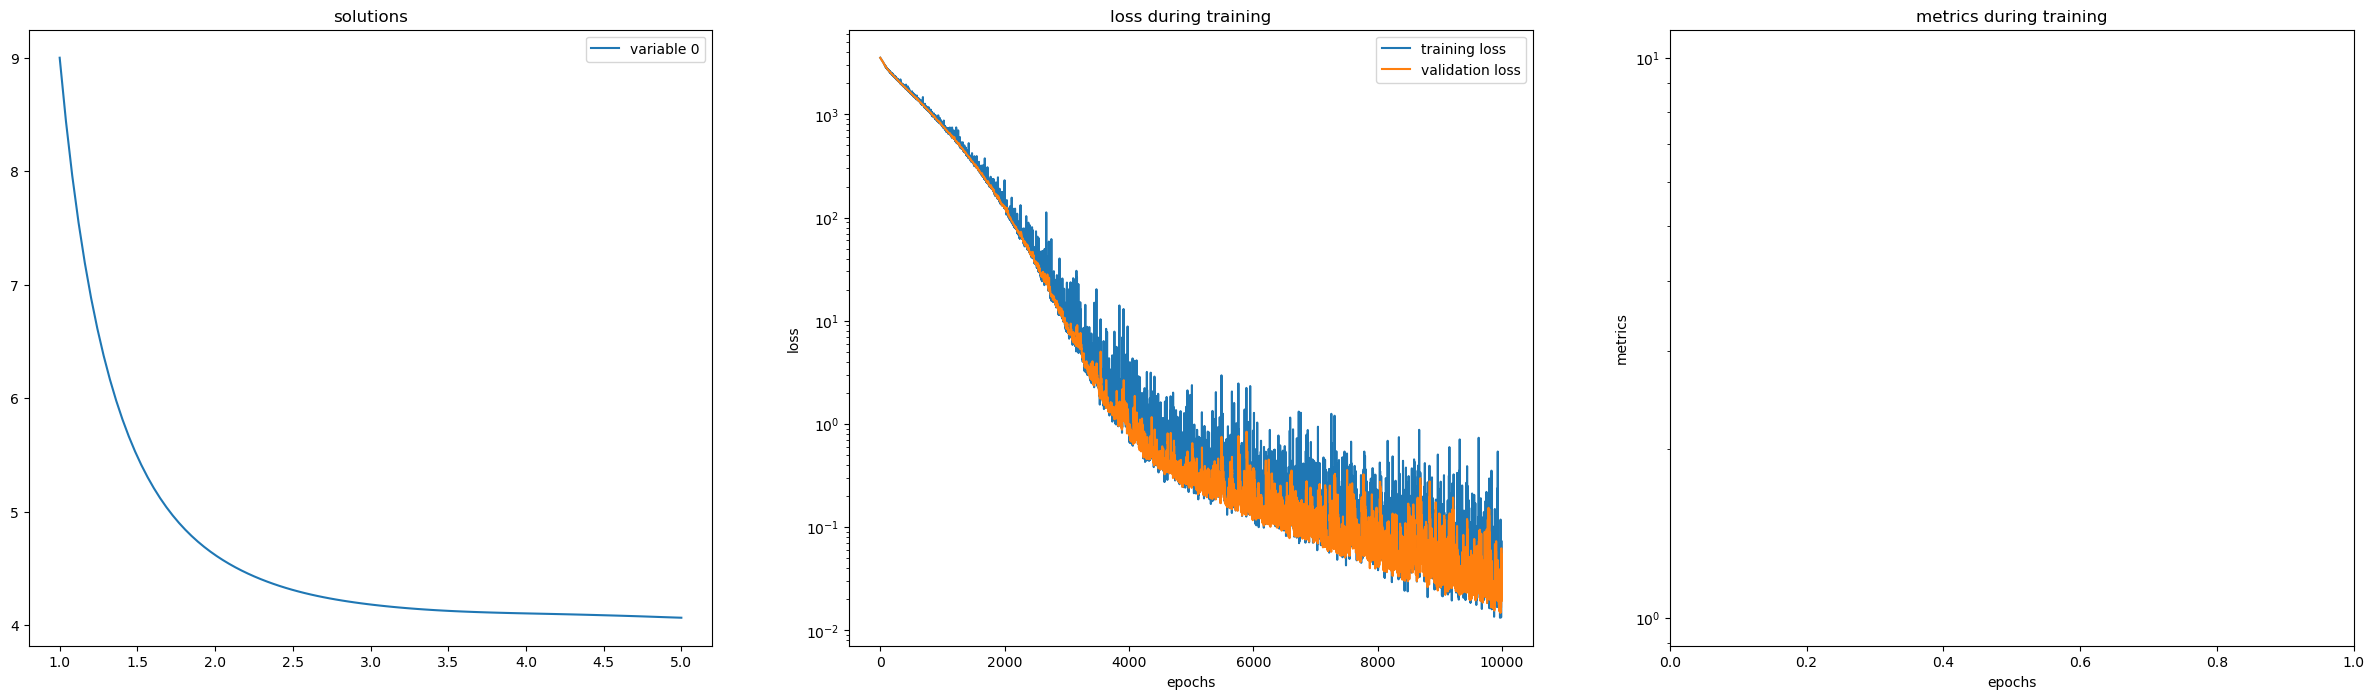

In [51]:
def ode_system(V, t):
    return [diff(V,t,order=2)*t + 4*diff(V,t)]
V0 = C3 + C4
V0dash = -3*C4

conditions = [IVP(t_0=1.0, u_0=V0, u_0_prime=V0dash)]

nets = [FCNN(actv=SinActv)]

g1 = Generator1D(4096, t_start, t_end, method='uniform')
monitor = Monitor1D(t_min=t_start, t_max=t_end, check_every=N)
# solver = Solver1D(ode_system, conditions, t_min=t_start, t_max=t_end, nets = nets, train_generator=g1, valid_generator=g1)
solver = Solver1D(ode_system, conditions, t_min=t_start, t_max=t_end, nets = nets)
solver.fit(max_epochs=N, callbacks = [monitor.to_callback()])
solution = solver.get_solution()

In [54]:
V_nn = solution(t, to_numpy=True)
V_an = C3 + C4/(t**3)

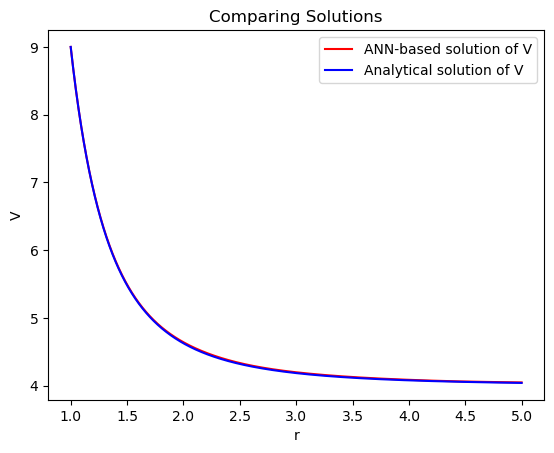

In [58]:
plt.title("Comparing Solutions")
plt.ylabel('V')
plt.xlabel('r')
plt.plot(t, V_nn, label='ANN-based solution of V', color = 'r')
plt.plot(t, V_an,label='Analytical solution of V', color = 'b')
plt.legend()
plt.savefig('lambda')
plt.show()